# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
from scipy.misc import imread, imresize, imshow
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.set_random_seed(30)

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [10]:
train_doc = np.random.permutation(open('Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data/val.csv').readlines())
batch_size = 5 #experiment with the batch size

Lets check the shape of the train images. 

In [5]:
source_path='Project_data'
train_file=source_path+"/train.csv"

with open(train_file) as f:
    lines = f.readlines()
    
# set of image sizes
s = set()

# For all images in the training set, find the shape and add it to the set. The set will hence contain all the different image sizes.
for l in lines:
    folder=source_path + "/train"+"/" + l.split(';')[0]
    imgs = os.listdir(folder)
    for i in imgs:
        img_name=folder + "/" + i
        image = imread(img_name)
        s.add(image.shape)

print(s)
    

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  app.launch_new_instance()


{(360, 360, 3), (120, 160, 3)}


We can see that there are two image sizes in the training data. To make it uniform we will resize all the images to size (120, 160)

Lets experiment resize, normalize and show apis on one single image before we use them in the generator. We can see how these functions modify the original entities. We will first try an image of size 360X360. In this case we will just resize it to size 120X120.

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


(360, 360, 3)
(120, 120, 3)


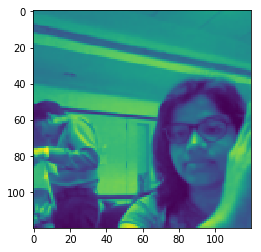

[[0.46666667 0.47058824 0.4627451  ... 0.54509804 0.5372549  0.52941176]
 [0.47843137 0.4745098  0.47058824 ... 0.5372549  0.52941176 0.5254902 ]
 [0.51372549 0.50980392 0.50980392 ... 0.53333333 0.5254902  0.52156863]
 ...
 [0.46666667 0.32941176 0.27058824 ... 0.25098039 0.27843137 0.29019608]
 [0.29019608 0.16078431 0.19607843 ... 0.25490196 0.29019608 0.29411765]
 [0.14117647 0.08627451 0.1254902  ... 0.2627451  0.28627451 0.28627451]]


In [28]:
img_name = 'Project_data/train/WIN_20180907_15_35_09_Pro_Right Swipe_new/WIN_20180907_15_35_09_Pro_00012.png'
image = imread(img_name)
# The original size of the image
print(image.shape)
resized = imresize(image, (120,120))
# size of the image after resize
print(resized.shape)
import matplotlib.pyplot as plt
plt.imshow(resized[:, : , 0])
plt.show()
print(resized[:, : , 0]/255)

Next, we will experiment on an image of size 120X160. In this case we will crop it to size 120X120.

(120, 160, 3)
(120, 120, 3)


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


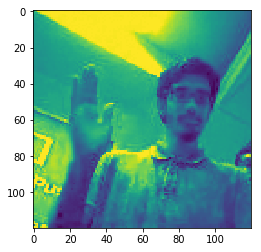

[[0.64313725 0.76078431 0.9372549  ... 0.39215686 0.36862745 0.36078431]
 [0.65098039 0.63921569 0.6627451  ... 0.38823529 0.36862745 0.35686275]
 [0.61568627 0.59607843 0.58431373 ... 0.38823529 0.36862745 0.35686275]
 ...
 [1.         1.         1.         ... 0.36862745 0.34117647 0.3254902 ]
 [0.45490196 0.89803922 1.         ... 0.35686275 0.36078431 0.34117647]
 [1.         0.98431373 0.97254902 ... 0.36862745 0.37254902 0.36470588]]


In [7]:
img_name = 'Project_data/train/WIN_20180925_17_08_43_Pro_Left_Swipe_new/WIN_20180925_17_08_43_Pro_00016.png'
image = imread(img_name)
# The original size of the image
print(image.shape)
resized = image[0:120,0:120]
# size of the image after resize
print(resized.shape)
import matplotlib.pyplot as plt
plt.imshow(resized[:, : , 0])
plt.show()
print(resized[:, : , 0]/255)

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [11]:
def generator(source_path, folder_list, batch_size):
    
    # We have experimented with different img_idx. To ensure fast training we sampled 20 images (leaving out multiples of 3).
    # Once we finalize a good model we took all 30 images and ran training for 40 epochs.
    
    #img_idx = [i for i in range(0, 30) if i % 3 != 0]
    img_idx = [i for i in range(0, 30)]
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(t)/batch_size) # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,30,120,160,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item  in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    #resized = imresize(image, (120,160))
                    
                    if image.shape[0] == 360:
                      # in case of 360 X 360 , resize the image to 120X120
                      resized = imresize(image, (120,120))
                    else:
                      # in case of 120 X 160 , crop the image to 120X120
                      resized = image[0:120,0:120]
                      
                    batch_data[folder,idx,:,:,0] = resized[:, : , 0]/255
                    batch_data[folder,idx,:,:,1] = resized[:, : , 1]/255
                    batch_data[folder,idx,:,:,2] = resized[:, : , 2]/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        remaining = len(t) - num_batches*batch_size
        if remaining > 0:
            batch_data = np.zeros((remaining,30,120,160,3))
            batch_labels = np.zeros((remaining,5))
            for folder in range(remaining):
                imgs = os.listdir(source_path+"/"+t[num_batches*batch_size + folder].split(';')[0])
                for idx,item in enumerate(img_idx):
                #for i in imgs:
                    image = imread(source_path+"/"+t[num_batches*batch_size + folder].split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #resized = imresize(image, (120,160))
                    
                    if image.shape[0] == 360:
                      # in case of 360 X 360 , resize the image to 120X120
                      resized = imresize(image, (120,120))
                    else:
                      # in case of 120 X 160 , crop the image to 120X120
                      resized = image[0:120,0:120]
                    
                    batch_data[folder,idx,:,:,0] = resized[:, : , 0]/255
                    batch_data[folder,idx,:,:,1] = resized[:, : , 1]/255
                    batch_data[folder,idx,:,:,2] = resized[:, : , 2]/255

                batch_labels[folder, int(t[folder + num_batches*batch_size].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [12]:
curr_dt_time = datetime.datetime.now()
train_path = 'Project_data/train'
val_path = 'Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 40 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


We have experimented with different value of "num_epochs" like 10, 15, 20 and 40.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Model 1


In [6]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam

In [16]:

#write your model here

# Define model
model = Sequential()
model.add(Conv3D(
    16, (3,3,3), activation='relu', input_shape=(20,120,160,3)
))
model.add(Conv3D(16, (3,3,3), activation='relu'))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, (3,3,3), activation='relu'))
model.add(Conv3D(32, (3,3,3), activation='relu'))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 18, 118, 158, 16)  1312      
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 16, 116, 156, 16)  6928      
_________________________________________________________________
max_pooling3d_10 (MaxPooling (None, 8, 58, 78, 16)     0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 58, 78, 16)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 6, 56, 76, 32)     13856     
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 4, 54, 74, 32)     27680     
_________________________________________________________________
max_pooling3d_11 (MaxPooling (None, 2, 27, 37, 32)     0         
__________

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [17]:
from keras.optimizers import Adam
optimiser = Adam() #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [19]:
#model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
model_name = 'model_1' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [13]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print ('steps_per_epoch %d' % steps_per_epoch)
print ('validation_steps %d' % validation_steps)

steps_per_epoch 133
validation_steps 20


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [21]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


123/133 [==========================>...] - ETA: 4s - loss: 1.6595 - categorical_accuracy: 0.1967

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 65s 492ms/step - loss: 1.6559 - categorical_accuracy: 0.1980 - val_loss: 1.6093 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_1/model.h5
Epoch 2/10
133/133 [==============================] - 59s 445ms/step - loss: 1.6096 - categorical_accuracy: 0.1790 - val_loss: 1.6087 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_1/model.h5
Epoch 3/10
133/133 [==============================] - 60s 448ms/step - loss: 1.6099 - categorical_accuracy: 0.1865 - val_loss: 1.6085 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model_1/model.h5
Epoch 4/10
133/133 [==============================] - 59s 441ms/step - loss: 1.6090 - categorical_accuracy: 0.1865 - val_loss: 1.6084 - val_categorical_accuracy: 0.2100

Epoch 00004: saving model to model_1/model.h5
Epoch 5/10
133/133 [==============================] - 59s 444ms/step - loss: 1.6091 - categorical_accuracy: 0.2030 - val_loss: 1.6079 - val_categor

From the results, we can conclude that the model 1 is not able to learn much from the training data. We need to modify the architecture to see how that influences results. We will go with simpler models compared to model 1.

## Model 2

In [36]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), activation='relu', input_shape=(20,120,160,3),
    padding='same'
))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 120, 160, 8)   656       
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 60, 80, 8)     0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10, 60, 80, 8)     0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 60, 80, 16)    3472      
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 5, 30, 40, 16)     0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 30, 40, 16)     0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 5, 30, 40, 32)     13856     
__________

In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_2' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


125/133 [===========================>..] - ETA: 3s - loss: 1.6090 - categorical_accuracy: 0.1904

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 62s 463ms/step - loss: 1.6089 - categorical_accuracy: 0.1940 - val_loss: 1.6072 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.60716, saving model to model_2/model.h5
Epoch 2/10
133/133 [==============================] - 60s 450ms/step - loss: 1.6089 - categorical_accuracy: 0.1875 - val_loss: 1.6070 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss improved from 1.60716 to 1.60702, saving model to model_2/model.h5
Epoch 3/10
133/133 [==============================] - 59s 445ms/step - loss: 1.6091 - categorical_accuracy: 0.1965 - val_loss: 1.6070 - val_categorical_accuracy: 0.2100

Epoch 00003: val_loss did not improve from 1.60702
Epoch 4/10
133/133 [==============================] - 59s 444ms/step - loss: 1.6092 - categorical_accuracy: 0.1739 - val_loss: 1.6071 - val_categorical_accuracy: 0.2300

Epoch 00004: val_loss did not improve from 1.60702

Epoch 00004: ReduceLROnPlateau reducing learning rate 

We can see that there is still some problem with the CNN. We expected the loss to reduce in every epoch, but its simply stuck at 1.6086. Lets choose a simpler network with the CNN layers arranged a little differently.

## Model 3

In [27]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), activation='relu', input_shape=(20,120,160,3),
    padding='same'
))
model.add(Conv3D(8, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_42 (Conv3D)           (None, 20, 120, 160, 8)   656       
_________________________________________________________________
conv3d_43 (Conv3D)           (None, 20, 120, 160, 8)   1736      
_________________________________________________________________
max_pooling3d_25 (MaxPooling (None, 10, 60, 80, 8)     0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 10, 60, 80, 8)     0         
_________________________________________________________________
conv3d_44 (Conv3D)           (None, 10, 60, 80, 16)    3472      
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 5, 30, 40, 16)     0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 5, 30, 40, 16)     0         
__________

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_3' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


131/133 [============================>.] - ETA: 0s - loss: 1.7041 - categorical_accuracy: 0.1802

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 57s 429ms/step - loss: 1.7026 - categorical_accuracy: 0.1805 - val_loss: 1.6092 - val_categorical_accuracy: 0.1800

Epoch 00001: val_loss improved from inf to 1.60925, saving model to model_3/model.h5
Epoch 2/15
133/133 [==============================] - 53s 399ms/step - loss: 1.6095 - categorical_accuracy: 0.2000 - val_loss: 1.6025 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss improved from 1.60925 to 1.60253, saving model to model_3/model.h5
Epoch 3/15
133/133 [==============================] - 54s 403ms/step - loss: 1.6045 - categorical_accuracy: 0.2000 - val_loss: 1.5638 - val_categorical_accuracy: 0.2700

Epoch 00003: val_loss improved from 1.60253 to 1.56376, saving model to model_3/model.h5
Epoch 4/15
133/133 [==============================] - 54s 402ms/step - loss: 1.3705 - categorical_accuracy: 0.3815 - val_loss: 1.1140 - val_categorical_accuracy: 0.5500

Epoch 00004: val_loss improved from 1.56376 to 1.11404, saving model

The results are now looking much better. We have hit a validation accuracy of 76%. Next, our aim is to optimize the network even further and reach over 80% validation accuracy.

## Model 4

In [30]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), activation='relu', input_shape=(20,120,160,3),
    padding='same'
))

model.add(Conv3D(16, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

model.add(Conv3D(32, (3,3,3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_49 (Conv3D)           (None, 20, 120, 160, 8)   656       
_________________________________________________________________
conv3d_50 (Conv3D)           (None, 20, 120, 160, 16)  3472      
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 10, 60, 80, 16)    0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 10, 60, 80, 16)    0         
_________________________________________________________________
conv3d_51 (Conv3D)           (None, 10, 60, 80, 32)    13856     
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 5, 30, 40, 32)     0         
_________________________________________________________________
dropout_41 (Dropout)         (None, 5, 30, 40, 32)     0         
__________

In [31]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_4' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


131/133 [============================>.] - ETA: 0s - loss: 2.3391 - categorical_accuracy: 0.2015

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 59s 446ms/step - loss: 2.3281 - categorical_accuracy: 0.2050 - val_loss: 1.6089 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.60887, saving model to model_3/model.h5
Epoch 2/15
133/133 [==============================] - 57s 427ms/step - loss: 1.5993 - categorical_accuracy: 0.1925 - val_loss: 1.6091 - val_categorical_accuracy: 0.2200

Epoch 00002: val_loss did not improve from 1.60887
Epoch 3/15
133/133 [==============================] - 56s 421ms/step - loss: 1.6357 - categorical_accuracy: 0.2301 - val_loss: 1.6059 - val_categorical_accuracy: 0.2000

Epoch 00003: val_loss improved from 1.60887 to 1.60592, saving model to model_3/model.h5
Epoch 4/15
133/133 [==============================] - 57s 427ms/step - loss: 1.5386 - categorical_accuracy: 0.2752 - val_loss: 1.4296 - val_categorical_accuracy: 0.2500

Epoch 00004: val_loss improved from 1.60592 to 1.42962, saving model to model_3/model.h5
Epoch 5/15
133/13

Since we are not able to achieve our target accuracy, we will now add some BatchNormalization layers to see if that normalization of the input to the activation function can help us improve accuracy.

## Model 5

In [8]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(20,120,160,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 20, 120, 160, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 120, 160, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 20, 120, 160, 8)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 20, 120, 160, 8)   1736      
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 120, 160, 8)   32        
_________________________________________________________________
activation_2 (Activation)    (None, 20, 120, 160, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 10, 60, 80, 8)     0         
__________

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_5' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/15


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


131/133 [============================>.] - ETA: 2s - loss: 1.4661 - categorical_accuracy: 0.4489

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 197s 1s/step - loss: 1.4538 - categorical_accuracy: 0.4556 - val_loss: 1.2187 - val_categorical_accuracy: 0.5900

Epoch 00001: val_loss improved from inf to 1.21867, saving model to model_5/model.h5
Epoch 2/15
133/133 [==============================] - 63s 472ms/step - loss: 0.9135 - categorical_accuracy: 0.6481 - val_loss: 1.4100 - val_categorical_accuracy: 0.3700

Epoch 00002: val_loss did not improve from 1.21867
Epoch 3/15
133/133 [==============================] - 63s 473ms/step - loss: 0.7161 - categorical_accuracy: 0.7283 - val_loss: 0.8620 - val_categorical_accuracy: 0.6600

Epoch 00003: val_loss improved from 1.21867 to 0.86203, saving model to model_5/model.h5
Epoch 4/15
133/133 [==============================] - 63s 475ms/step - loss: 0.6280 - categorical_accuracy: 0.7599 - val_loss: 0.8375 - val_categorical_accuracy: 0.6400

Epoch 00004: val_loss improved from 0.86203 to 0.83752, saving model to model_5/model.h5
Epoch 5/15
133/133 

## Model 6

In [10]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(20,120,160,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 20, 120, 160, 8)   656       
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 120, 160, 8)   32        
_________________________________________________________________
activation_6 (Activation)    (None, 20, 120, 160, 8)   0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 20, 120, 160, 8)   1736      
_________________________________________________________________
batch_normalization_7 (Batch (None, 20, 120, 160, 8)   32        
_________________________________________________________________
activation_7 (Activation)    (None, 20, 120, 160, 8)   0         
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 60, 80, 8)     0         
__________

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_6' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


129/133 [============================>.] - ETA: 1s - loss: 1.7015 - categorical_accuracy: 0.3814

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 58s 434ms/step - loss: 1.7009 - categorical_accuracy: 0.3824 - val_loss: 2.4749 - val_categorical_accuracy: 0.2400

Epoch 00001: val_categorical_accuracy improved from -inf to 0.24000, saving model to model_5/model.h5
Epoch 2/10
133/133 [==============================] - 54s 409ms/step - loss: 1.3902 - categorical_accuracy: 0.4747 - val_loss: 2.2641 - val_categorical_accuracy: 0.2500

Epoch 00002: val_categorical_accuracy improved from 0.24000 to 0.25000, saving model to model_5/model.h5
Epoch 3/10
133/133 [==============================] - 54s 408ms/step - loss: 1.1592 - categorical_accuracy: 0.5489 - val_loss: 2.0507 - val_categorical_accuracy: 0.3400

Epoch 00003: val_categorical_accuracy improved from 0.25000 to 0.34000, saving model to model_5/model.h5
Epoch 4/10
133/133 [==============================] - 54s 407ms/step - loss: 1.0183 - categorical_accuracy: 0.5805 - val_loss: 1.2268 - val_categorical_accuracy: 0.4600

Epoch 00004: val_ca

## Model 7

In [15]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(20,120,160,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 20, 120, 160, 8)   656       
_________________________________________________________________
batch_normalization_14 (Batc (None, 20, 120, 160, 8)   32        
_________________________________________________________________
activation_14 (Activation)   (None, 20, 120, 160, 8)   0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 20, 120, 160, 8)   0         
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 20, 120, 160, 16)  3472      
_________________________________________________________________
batch_normalization_15 (Batc (None, 20, 120, 160, 16)  64        
_________________________________________________________________
activation_15 (Activation)   (None, 20, 120, 160, 16)  0         
__________

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_7' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/10


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  del sys.path[0]
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


122/133 [==========================>...] - ETA: 5s - loss: 1.7421 - categorical_accuracy: 0.3082

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 73s 548ms/step - loss: 1.7171 - categorical_accuracy: 0.3123 - val_loss: 2.8447 - val_categorical_accuracy: 0.1600

Epoch 00001: val_categorical_accuracy improved from -inf to 0.16000, saving model to model_7/model.h5
Epoch 2/10
133/133 [==============================] - 66s 497ms/step - loss: 1.5344 - categorical_accuracy: 0.3865 - val_loss: 2.7364 - val_categorical_accuracy: 0.1900

Epoch 00002: val_categorical_accuracy improved from 0.16000 to 0.19000, saving model to model_7/model.h5
Epoch 3/10
133/133 [==============================] - 66s 496ms/step - loss: 1.2642 - categorical_accuracy: 0.4887 - val_loss: 3.6635 - val_categorical_accuracy: 0.1700

Epoch 00003: val_categorical_accuracy did not improve from 0.19000
Epoch 4/10
133/133 [==============================] - 67s 500ms/step - loss: 1.1895 - categorical_accuracy: 0.5243 - val_loss: 3.5406 - val_categorical_accuracy: 0.3200

Epoch 00004: val_categorical_accuracy improved from 0.190

## Model 8

In [26]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(30,120,160,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 30, 120, 160, 8)   656       
_________________________________________________________________
batch_normalization_43 (Batc (None, 30, 120, 160, 8)   32        
_________________________________________________________________
activation_43 (Activation)   (None, 30, 120, 160, 8)   0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 30, 120, 160, 8)   1736      
_________________________________________________________________
batch_normalization_44 (Batc (None, 30, 120, 160, 8)   32        
_________________________________________________________________
activation_44 (Activation)   (None, 30, 120, 160, 8)   0         
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 15, 60, 80, 8)     0         
__________

In [27]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_8' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


Epoch 1/20
123/133 [==========================>...] - ETA: 6s - loss: 1.5319 - categorical_accuracy: 0.3659

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 94s 706ms/step - loss: 1.5286 - categorical_accuracy: 0.3679 - val_loss: 1.2355 - val_categorical_accuracy: 0.5200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.52000, saving model to model_8/model.h5
Epoch 2/20
133/133 [==============================] - 88s 664ms/step - loss: 1.2731 - categorical_accuracy: 0.4942 - val_loss: 2.0901 - val_categorical_accuracy: 0.3100

Epoch 00002: val_categorical_accuracy did not improve from 0.52000
Epoch 3/20
133/133 [==============================] - 88s 665ms/step - loss: 1.1474 - categorical_accuracy: 0.5378 - val_loss: 1.7218 - val_categorical_accuracy: 0.4100

Epoch 00003: val_categorical_accuracy did not improve from 0.52000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/20
133/133 [==============================] - 89s 667ms/step - loss: 0.9362 - categorical_accuracy: 0.6541 - val_loss: 1.1677 - val_categorical_accuracy: 0.5700

Epoch 00004: v

As per our analysis of the different models, Model 8 looks quite good. We can see that at different epochs it has a stable accuracy of nearly 70% on the validation set. If we increase the number of epochs from 20 to 40, probably Model 8 can lead us to over 80% accuracy on the validation set.

## Model 9

In [30]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(30,120,160,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_46 (Conv3D)           (None, 30, 120, 160, 8)   656       
_________________________________________________________________
batch_normalization_57 (Batc (None, 30, 120, 160, 8)   32        
_________________________________________________________________
activation_57 (Activation)   (None, 30, 120, 160, 8)   0         
_________________________________________________________________
conv3d_47 (Conv3D)           (None, 30, 120, 160, 8)   1736      
_________________________________________________________________
batch_normalization_58 (Batc (None, 30, 120, 160, 8)   32        
_________________________________________________________________
activation_58 (Activation)   (None, 30, 120, 160, 8)   0         
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 15, 60, 80, 8)     0         
__________

In [31]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_9' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


122/133 [==========================>...] - ETA: 7s - loss: 1.5428 - categorical_accuracy: 0.3475

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 96s 720ms/step - loss: 1.5458 - categorical_accuracy: 0.3514 - val_loss: 2.4647 - val_categorical_accuracy: 0.2500

Epoch 00001: val_categorical_accuracy improved from -inf to 0.25000, saving model to model_9/model.h5
Epoch 2/40
133/133 [==============================] - 89s 671ms/step - loss: 1.3182 - categorical_accuracy: 0.4491 - val_loss: 1.4263 - val_categorical_accuracy: 0.4700

Epoch 00002: val_categorical_accuracy improved from 0.25000 to 0.47000, saving model to model_9/model.h5
Epoch 3/40
133/133 [==============================] - 89s 669ms/step - loss: 1.2216 - categorical_accuracy: 0.5018 - val_loss: 0.9392 - val_categorical_accuracy: 0.6400

Epoch 00003: val_categorical_accuracy improved from 0.47000 to 0.64000, saving model to model_9/model.h5
Epoch 4/40
133/133 [==============================] - 89s 669ms/step - loss: 0.9951 - categorical_accuracy: 0.5945 - val_loss: 1.7473 - val_categorical_accuracy: 0.3800

Epoch 00004: val_ca


Epoch 00030: val_categorical_accuracy did not improve from 0.83000
Epoch 31/40
133/133 [==============================] - 90s 680ms/step - loss: 0.2731 - categorical_accuracy: 0.9223 - val_loss: 0.5534 - val_categorical_accuracy: 0.8300

Epoch 00031: val_categorical_accuracy did not improve from 0.83000
Epoch 32/40
133/133 [==============================] - 90s 680ms/step - loss: 0.3030 - categorical_accuracy: 0.9113 - val_loss: 0.5625 - val_categorical_accuracy: 0.8200

Epoch 00032: val_categorical_accuracy did not improve from 0.83000
Epoch 33/40
133/133 [==============================] - 90s 677ms/step - loss: 0.2638 - categorical_accuracy: 0.9158 - val_loss: 0.5598 - val_categorical_accuracy: 0.8200

Epoch 00033: val_categorical_accuracy did not improve from 0.83000

Epoch 00033: ReduceLROnPlateau reducing learning rate to 2.4414063659605745e-07.
Epoch 34/40
133/133 [==============================] - 90s 677ms/step - loss: 0.2771 - categorical_accuracy: 0.9173 - val_loss: 0.5601 -

## Model 10

In the previous model - Model 9, we have got validation accuracy of 83%. For Model 10, we will modify the inputs a little. Until Model 9, we were using images of size 120 X 160, for Model 10, we will try using images of dimension 120 X 120 to see if that helps the model learn better.

In [8]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(30,120,120,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 30, 120, 120, 8)   656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_1 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 30, 120, 120, 8)   1736      
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 120, 120, 8)   32        
_________________________________________________________________
activation_2 (Activation)    (None, 30, 120, 120, 8)   0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 15, 60, 60, 8)     0         
__________

In [9]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_10' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/40


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


131/133 [============================>.] - ETA: 3s - loss: 1.6440 - categorical_accuracy: 0.3160

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - 250s 2s/step - loss: 1.6474 - categorical_accuracy: 0.3128 - val_loss: 2.2583 - val_categorical_accuracy: 0.2300

Epoch 00001: val_categorical_accuracy improved from -inf to 0.23000, saving model to model_10/model.h5
Epoch 2/40
131/133 [============================>.] - ETA: 0s - loss: 1.4500 - categorical_accuracy: 0.3969

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 72s 542ms/step - loss: 1.4555 - categorical_accuracy: 0.3950 - val_loss: 1.4106 - val_categorical_accuracy: 0.3900

Epoch 00002: val_categorical_accuracy improved from 0.23000 to 0.39000, saving model to model_10/model.h5
Epoch 3/40
133/133 [==============================] - 71s 532ms/step - loss: 1.2659 - categorical_accuracy: 0.4782 - val_loss: 1.5674 - val_categorical_accuracy: 0.4500

Epoch 00003: val_categorical_accuracy improved from 0.39000 to 0.45000, saving model to model_10/model.h5
Epoch 4/40
133/133 [==============================] - 74s 554ms/step - loss: 1.0994 - categorical_accuracy: 0.5634 - val_loss: 1.3149 - val_categorical_accuracy: 0.5100

Epoch 00004: val_categorical_accuracy improved from 0.45000 to 0.51000, saving model to model_10/model.h5
Epoch 5/40
133/133 [==============================] - 72s 544ms/step - loss: 0.9934 - categorical_accuracy: 0.5985 - val_loss: 1.2421 - val_categorical_accuracy: 0.5300

Epoch 00005: 

133/133 [==============================] - 72s 544ms/step - loss: 0.2417 - categorical_accuracy: 0.9308 - val_loss: 0.7185 - val_categorical_accuracy: 0.7300

Epoch 00032: val_categorical_accuracy did not improve from 0.81000

Epoch 00032: ReduceLROnPlateau reducing learning rate to 9.765625463842298e-07.
Epoch 33/40
133/133 [==============================] - 71s 534ms/step - loss: 0.2774 - categorical_accuracy: 0.9103 - val_loss: 0.7210 - val_categorical_accuracy: 0.7200

Epoch 00033: val_categorical_accuracy did not improve from 0.81000
Epoch 34/40
133/133 [==============================] - 70s 530ms/step - loss: 0.2306 - categorical_accuracy: 0.9263 - val_loss: 0.7179 - val_categorical_accuracy: 0.7200

Epoch 00034: val_categorical_accuracy did not improve from 0.81000

Epoch 00034: ReduceLROnPlateau reducing learning rate to 4.882812731921149e-07.
Epoch 35/40
133/133 [==============================] - 71s 533ms/step - loss: 0.3169 - categorical_accuracy: 0.8892 - val_loss: 0.7141 -

We ran training for 40 epochs, but our best validation accuracy reached only 81%. So, Model 9 is still our best choice.

## Model 11

In [27]:
model = Sequential()

model.add(Conv3D(
    8, (3,3,3), input_shape=(30,120,160,3),
    padding='same'))

model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv3D(8, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv3D(16, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3,3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# softmax layer
model.add(Dense(5, activation='softmax'))

# model summary
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_23 (Conv3D)           (None, 30, 120, 160, 8)   656       
_________________________________________________________________
batch_normalization_31 (Batc (None, 30, 120, 160, 8)   32        
_________________________________________________________________
activation_31 (Activation)   (None, 30, 120, 160, 8)   0         
_________________________________________________________________
conv3d_24 (Conv3D)           (None, 30, 120, 160, 8)   1736      
_________________________________________________________________
batch_normalization_32 (Batc (None, 30, 120, 160, 8)   32        
_________________________________________________________________
activation_32 (Activation)   (None, 30, 120, 160, 8)   0         
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 15, 60, 80, 8)     0         
__________

In [23]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_11' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]

model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch 1/60
127/133 [===========================>..] - ETA: 3s - loss: 1.5830 - categorical_accuracy: 0.3323

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 94s 707ms/step - loss: 1.5763 - categorical_accuracy: 0.3363 - val_loss: 1.6588 - val_categorical_accuracy: 0.4400

Epoch 00001: val_categorical_accuracy improved from -inf to 0.44000, saving model to model_11/model.h5
Epoch 2/60
133/133 [==============================] - 88s 660ms/step - loss: 1.3058 - categorical_accuracy: 0.4471 - val_loss: 1.5176 - val_categorical_accuracy: 0.4800

Epoch 00002: val_categorical_accuracy improved from 0.44000 to 0.48000, saving model to model_11/model.h5
Epoch 3/60
133/133 [==============================] - 88s 660ms/step - loss: 1.1324 - categorical_accuracy: 0.5394 - val_loss: 1.5819 - val_categorical_accuracy: 0.4100

Epoch 00003: val_categorical_accuracy did not improve from 0.48000
Epoch 4/60
133/133 [==============================] - 88s 663ms/step - loss: 1.0594 - categorical_accuracy: 0.5769 - val_loss: 1.0434 - val_categorical_accuracy: 0.6100

Epoch 00004: val_categorical_accuracy improved from 0.4


Epoch 00031: val_categorical_accuracy improved from 0.80000 to 0.81000, saving model to model_11/model.h5

Epoch 00031: ReduceLROnPlateau reducing learning rate to 5.76480058953166e-05.
Epoch 32/60
133/133 [==============================] - 90s 679ms/step - loss: 0.1702 - categorical_accuracy: 0.9549 - val_loss: 0.5777 - val_categorical_accuracy: 0.7800

Epoch 00032: val_categorical_accuracy did not improve from 0.81000
Epoch 33/60
133/133 [==============================] - 90s 674ms/step - loss: 0.1753 - categorical_accuracy: 0.9549 - val_loss: 0.5978 - val_categorical_accuracy: 0.7900

Epoch 00033: val_categorical_accuracy did not improve from 0.81000

Epoch 00033: ReduceLROnPlateau reducing learning rate to 4.0353603617404586e-05.
Epoch 34/60
133/133 [==============================] - 90s 677ms/step - loss: 0.1457 - categorical_accuracy: 0.9654 - val_loss: 0.6112 - val_categorical_accuracy: 0.7700

Epoch 00034: val_categorical_accuracy did not improve from 0.81000
Epoch 35/60
133/1

## Model 12 : Conv 2D + RNN(LSTM/GRU)


In [38]:
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Reshape, Lambda
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Conv2D, LSTM, TimeDistributed, Flatten, Input, GRU, GlobalAveragePooling2D
from keras.applications import VGG19

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

print ('steps_per_epoch %d' % steps_per_epoch)
print ('validation_steps %d' % validation_steps)

steps_per_epoch 133
validation_steps 20


In [41]:
input_shape = (120, 120, 3)
model = Sequential()
x_input = Input(shape= input_shape)

x_output = Conv2D(filters=8, kernel_size=(3,3), padding='same')(x_input)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = Conv2D(filters=8, kernel_size=(3,3),padding='same')(x_output)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = MaxPooling2D(pool_size=(2, 2))(x_output)
x_output = Dropout(0.25)(x_output)

x_output = Conv2D(filters=16, kernel_size=(3,3), padding='same')(x_output)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = Conv2D(filters=16, kernel_size=(3,3), )(x_output)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = MaxPooling2D(pool_size=(2, 2))(x_output)
x_output = Dropout(0.25)(x_output)


x_output = Conv2D(filters=32, kernel_size=(3,3), padding='same')(x_output)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = MaxPooling2D(pool_size=(2, 2))(x_output)
x_output = Dropout(0.25)(x_output)

x_output = Conv2D(filters=64, kernel_size=(3,3), padding='same')(x_output)
x_output = BatchNormalization()(x_output)
x_output = Activation('relu')(x_output)
x_output = MaxPooling2D(pool_size=(2, 2))(x_output)
x_output = Dropout(0.25)(x_output)

base_model = Model(x_input, x_output)

model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))
model.add(GRU(256, activation='relu', recurrent_activation='hard_sigmoid', dropout=0.2))
model.add(Dense(5, activation='softmax'))
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, None, 7, 7, 64)    28008     
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 3136)        0         
_________________________________________________________________
gru_11 (GRU)                 (None, 256)               2605824   
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 1285      
Total params: 2,635,117
Trainable params: 2,634,829
Non-trainable params: 288
_________________________________________________________________
None


In [42]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_13' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]


In [43]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


131/133 [============================>.] - ETA: 1s - loss: 8.2109 - categorical_accuracy: 0.2397

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - 75s 562ms/step - loss: 8.1126 - categorical_accuracy: 0.2386 - val_loss: 1.7450 - val_categorical_accuracy: 0.2600

Epoch 00001: val_categorical_accuracy improved from -inf to 0.26000, saving model to model_13/model.h5
Epoch 2/5
131/133 [============================>.] - ETA: 0s - loss: 1.3871 - categorical_accuracy: 0.3740

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 70s 525ms/step - loss: 1.3910 - categorical_accuracy: 0.3684 - val_loss: 1.4279 - val_categorical_accuracy: 0.4000

Epoch 00002: val_categorical_accuracy improved from 0.26000 to 0.40000, saving model to model_13/model.h5
Epoch 3/5
133/133 [==============================] - 72s 538ms/step - loss: 1.2543 - categorical_accuracy: 0.4436 - val_loss: 1.6524 - val_categorical_accuracy: 0.3700

Epoch 00003: val_categorical_accuracy did not improve from 0.40000
Epoch 4/5
133/133 [==============================] - 71s 530ms/step - loss: 1.1200 - categorical_accuracy: 0.5343 - val_loss: 1.4255 - val_categorical_accuracy: 0.4000

Epoch 00004: val_categorical_accuracy did not improve from 0.40000
Epoch 5/5
133/133 [==============================] - 71s 533ms/step - loss: 1.1014 - categorical_accuracy: 0.5409 - val_loss: 1.9618 - val_categorical_accuracy: 0.3700

Epoch 00005: val_categorical_accuracy did not improve from 0.40000


In [44]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


121/133 [==========================>...] - ETA: 6s - loss: 1.0325 - categorical_accuracy: 0.5554

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 76s 569ms/step - loss: 1.0144 - categorical_accuracy: 0.5624 - val_loss: 1.7454 - val_categorical_accuracy: 0.4300

Epoch 00001: val_categorical_accuracy improved from 0.40000 to 0.43000, saving model to model_13/model.h5
Epoch 2/5
133/133 [==============================] - 72s 541ms/step - loss: 0.9608 - categorical_accuracy: 0.5935 - val_loss: 1.4348 - val_categorical_accuracy: 0.4800

Epoch 00002: val_categorical_accuracy improved from 0.43000 to 0.48000, saving model to model_13/model.h5
Epoch 3/5
133/133 [==============================] - 71s 534ms/step - loss: 0.8789 - categorical_accuracy: 0.6266 - val_loss: 1.3274 - val_categorical_accuracy: 0.4600

Epoch 00003: val_categorical_accuracy did not improve from 0.48000
Epoch 4/5
133/133 [==============================] - 71s 537ms/step - loss: 0.7903 - categorical_accuracy: 0.6622 - val_loss: 1.4391 - val_categorical_accuracy: 0.4400

Epoch 00004: val_categorical_accuracy did not improve f

In [45]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


111/133 [========================>.....] - ETA: 11s - loss: 0.7635 - categorical_accuracy: 0.7027

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 78s 589ms/step - loss: 0.7606 - categorical_accuracy: 0.7043 - val_loss: 1.1718 - val_categorical_accuracy: 0.5300

Epoch 00001: val_categorical_accuracy did not improve from 0.64000
Epoch 2/5
133/133 [==============================] - 70s 529ms/step - loss: 0.6546 - categorical_accuracy: 0.7479 - val_loss: 0.9642 - val_categorical_accuracy: 0.6200

Epoch 00002: val_categorical_accuracy did not improve from 0.64000
Epoch 3/5
133/133 [==============================] - 73s 550ms/step - loss: 0.6452 - categorical_accuracy: 0.7539 - val_loss: 1.0016 - val_categorical_accuracy: 0.5800

Epoch 00003: val_categorical_accuracy did not improve from 0.64000
Epoch 4/5
133/133 [==============================] - 70s 526ms/step - loss: 0.6433 - categorical_accuracy: 0.7419 - val_loss: 1.2722 - val_categorical_accuracy: 0.5400

Epoch 00004: val_categorical_accuracy did not improve from 0.64000

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.000500

#### Result of Conv2d + LRU => we got 64% accurancy on validation data and approx 78% on train data

## Model 13 :  Transfer learning +  RNN

In [29]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# freeze the layers in base model
for layer in base_model.layers:
    layer.trainable = False
model = Sequential()

model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))
model.add(GRU(256, activation='relu', recurrent_activation='hard_sigmoid', dropout=0.2))
model.add(Dense(5, activation='softmax'))
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 3, 3, 512)   20024384  
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 4608)        0         
_________________________________________________________________
gru_1 (GRU)                  (None, 256)               3736320   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 23,761,989
Trainable params: 3,737,605
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [33]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_VGGNET_TL' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]


In [34]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


122/133 [==========================>...] - ETA: 6s - loss: 0.2341 - categorical_accuracy: 0.9213

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - 88s 665ms/step - loss: 0.2316 - categorical_accuracy: 0.9203 - val_loss: 1.1754 - val_categorical_accuracy: 0.6200

Epoch 00001: val_categorical_accuracy improved from -inf to 0.62000, saving model to model_VGGNET_TL/model.h5
Epoch 2/20
123/133 [==========================>...] - ETA: 5s - loss: 0.2095 - categorical_accuracy: 0.9301

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 85s 641ms/step - loss: 0.2087 - categorical_accuracy: 0.9283 - val_loss: 0.9440 - val_categorical_accuracy: 0.6500

Epoch 00002: val_categorical_accuracy improved from 0.62000 to 0.65000, saving model to model_VGGNET_TL/model.h5
Epoch 3/20
133/133 [==============================] - 85s 641ms/step - loss: 0.1064 - categorical_accuracy: 0.9744 - val_loss: 0.9125 - val_categorical_accuracy: 0.6800

Epoch 00003: val_categorical_accuracy improved from 0.65000 to 0.68000, saving model to model_VGGNET_TL/model.h5
Epoch 4/20
133/133 [==============================] - 85s 641ms/step - loss: 0.0681 - categorical_accuracy: 0.9789 - val_loss: 1.1988 - val_categorical_accuracy: 0.6700

Epoch 00004: val_categorical_accuracy did not improve from 0.68000
Epoch 5/20
133/133 [==============================] - 85s 641ms/step - loss: 0.0347 - categorical_accuracy: 0.9955 - val_loss: 1.0454 - val_categorical_accuracy: 0.6900

Epoch 00005: val_categorical_accuracy 

####  Model based on transfer learning and RNN :Validation accurancy stuck on 70% while Training accurancy reached to 99.99 %  which means this model is highly overfittting

## Model 14

In [47]:
## To overcome the problem of overfitting, we need to dropout and batch normalization

# To remove overfitting , we will batch normalization and drop out
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# freeze the layers in base model
for layer in base_model.layers:
    layer.trainable = False

    # Get the output from the base model 
base_model_ouput = base_model.output
    
x = GlobalAveragePooling2D()(base_model_ouput)
model = Sequential()
base_model = Model(inputs=base_model.input, outputs=x)
model = Sequential()
model.add(TimeDistributed(base_model, input_shape=base_model.input_shape))
model.add(TimeDistributed(Flatten(input_shape=base_model.input_shape[1:])))
model.add(GRU(256, activation='relu', recurrent_activation='hard_sigmoid', dropout=0.2))
model.add(Dropout(0.25))
model.add(Dense(5, activation='softmax'))
optimiser = Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_17 (TimeDis (None, None, 512)         20024384  
_________________________________________________________________
time_distributed_18 (TimeDis (None, None, 512)         0         
_________________________________________________________________
gru_9 (GRU)                  (None, 256)               590592    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 1285      
Total params: 20,616,261
Trainable params: 591,877
Non-trainable params: 20,024,384
_________________________________________________________________
None


In [48]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_VGGNET_TL_1' + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
#filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

filepath = model_name + 'model.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)
callbacks_list = [checkpoint, LR]


In [50]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=10, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch 1/10
109/133 [=======================>......] - ETA: 13s - loss: 1.5924 - categorical_accuracy: 0.3028

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 86s 649ms/step - loss: 1.5614 - categorical_accuracy: 0.3218 - val_loss: 1.3465 - val_categorical_accuracy: 0.4600

Epoch 00001: val_categorical_accuracy improved from -inf to 0.46000, saving model to model_VGGNET_TL_1/model.h5
Epoch 2/10
133/133 [==============================] - 83s 626ms/step - loss: 1.3087 - categorical_accuracy: 0.4627 - val_loss: 1.1758 - val_categorical_accuracy: 0.5400

Epoch 00002: val_categorical_accuracy improved from 0.46000 to 0.54000, saving model to model_VGGNET_TL_1/model.h5
Epoch 3/10
133/133 [==============================] - 83s 626ms/step - loss: 1.1587 - categorical_accuracy: 0.5208 - val_loss: 1.1492 - val_categorical_accuracy: 0.5700

Epoch 00003: val_categorical_accuracy improved from 0.54000 to 0.57000, saving model to model_VGGNET_TL_1/model.h5
Epoch 4/10
133/133 [==============================] - 83s 627ms/step - loss: 1.0419 - categorical_accuracy: 0.5975 - val_loss: 0.9413 - val_categorical_accurac

In [51]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=5, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/5


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


 99/133 [=====================>........] - ETA: 19s - loss: 0.6153 - categorical_accuracy: 0.7657

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


133/133 [==============================] - 86s 646ms/step - loss: 0.6181 - categorical_accuracy: 0.7674 - val_loss: 0.7109 - val_categorical_accuracy: 0.7000

Epoch 00001: val_categorical_accuracy did not improve from 0.70000
Epoch 2/5
 97/133 [====================>.........] - ETA: 19s - loss: 0.5639 - categorical_accuracy: 0.7918

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


133/133 [==============================] - 83s 626ms/step - loss: 0.5812 - categorical_accuracy: 0.7744 - val_loss: 0.7657 - val_categorical_accuracy: 0.6700

Epoch 00002: val_categorical_accuracy did not improve from 0.70000
Epoch 3/5
133/133 [==============================] - 83s 628ms/step - loss: 0.5008 - categorical_accuracy: 0.8105 - val_loss: 0.7574 - val_categorical_accuracy: 0.7100

Epoch 00003: val_categorical_accuracy improved from 0.70000 to 0.71000, saving model to model_VGGNET_TL_1/model.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/5
133/133 [==============================] - 84s 628ms/step - loss: 0.4557 - categorical_accuracy: 0.8261 - val_loss: 0.6602 - val_categorical_accuracy: 0.7300

Epoch 00004: val_categorical_accuracy improved from 0.71000 to 0.73000, saving model to model_VGGNET_TL_1/model.h5
Epoch 5/5
133/133 [==============================] - 83s 627ms/step - loss: 0.4322 - categorical_accuracy: 0.8501 - val_loss:

####  Model based on transfer learning and RNN :Validation accurancy improved to 73% after normalization and dropouts while Training accurancy = 85% 

# Recommended Final Model

## MODEL 9
- Model 9 is our best model. It has provided an accuracy of 83% on the validation set consistently over multiple epochs. Also, it has not overfit the training data (unlike the previous models) with a training accuracy between 87-90%.

### Model 9 can be downloaded from here:
https://drive.google.com/drive/folders/1YDOavo0fBxQXc77tNTevpvRxqtanJeOy?usp=sharing